#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

In [ ]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


# Seq2Seq 구조

In [ ]:
# coding: utf-8
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')

        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=False)

        self.params = self.embed.params + self.rnn.params
        self.grads = self.embed.grads + self.rnn.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.rnn.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.rnn.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')

        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True)

        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.rnn, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.rnn.set_state(h)

        out = self.embed.forward(xs)
        out = self.rnn.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.rnn.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.rnn.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.rnn.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.rnn.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


# 학습 데이터

본 실습에서 사용할 데이터는 덧셈 데이터입니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/addition.png?raw=true" width=500>

모든 입력 데이터는 공백 포함 7자이며,

모든 출력 데이터 또한 공백 포함 5자로 고정합니다.


샘플 별로 길이가 다르기 때문에, 이를 맞춰주기 위해 적절히 공백을 추가합니다
이러한 작업을 Padding이라고 합니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/addition2.png?raw=true" width=500>


In [ ]:
# 데이터 예시
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
print(x_train[0])
print(t_train[0])
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 
[ 5 11  0  0  2  0  3]
[ 6  0 11  7  5]
 811+17
_189 


| 에폭 1 |  반복 1 / 703 | 시간 0[s] | 손실 4.09
| 에폭 1 |  반복 21 / 703 | 시간 0[s] | 손실 2.45
| 에폭 1 |  반복 41 / 703 | 시간 0[s] | 손실 1.93
| 에폭 1 |  반복 61 / 703 | 시간 0[s] | 손실 1.95
| 에폭 1 |  반복 81 / 703 | 시간 1[s] | 손실 1.93
| 에폭 1 |  반복 101 / 703 | 시간 1[s] | 손실 1.94
| 에폭 1 |  반복 121 / 703 | 시간 1[s] | 손실 1.92
| 에폭 1 |  반복 141 / 703 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 161 / 703 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 181 / 703 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 201 / 703 | 시간 3[s] | 손실 1.84
| 에폭 1 |  반복 221 / 703 | 시간 3[s] | 손실 1.81
| 에폭 1 |  반복 241 / 703 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 261 / 703 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 281 / 703 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 301 / 703 | 시간 4[s] | 손실 1.74
| 에폭 1 |  반복 321 / 703 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 341 / 703 | 시간 5[s] | 손실 1.72
| 에폭 1 |  반복 361 / 703 | 시간 5[s] | 손실 1.70
| 에폭 1 |  반복 381 / 703 | 시간 6[s] | 손실 1.68
| 에폭 1 |  반복 401 / 703 | 시간 6[s] | 손실 1.67
| 에폭 1 |  반복 421 / 703 | 시간 6[s] | 손실 1.64
| 에폭 1 |  반복 441 / 703 | 시간 6[s] | 손실 1.64
| 에폭 1 |  반복 461 

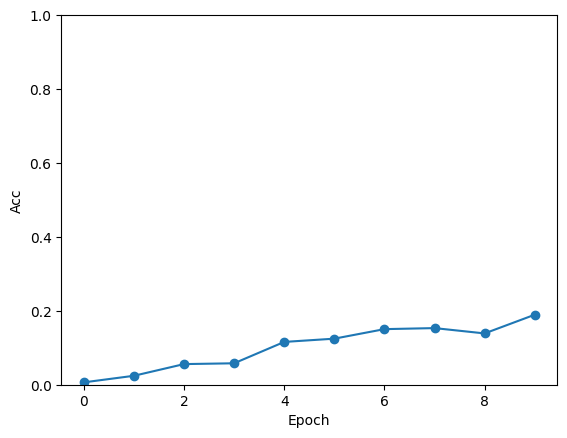

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 64
max_epoch = 10
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=False)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0, 1.0)
plt.show()

# Seq2Seq with Attention

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh


class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.rnn.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.rnn.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')

        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f') # Encoder Context Vector + Decoder Hidden Vector
        affine_b = np.zeros(V).astype('f')

        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True)
        self.embed = TimeEmbedding(embed_W)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.rnn, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.rnn.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.rnn.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.rnn.backward(ddec_hs)
        dh = self.rnn.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.rnn.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.rnn.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 703 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 703 | 시간 0[s] | 손실 2.06
| 에폭 1 |  반복 41 / 703 | 시간 0[s] | 손실 1.87
| 에폭 1 |  반복 61 / 703 | 시간 1[s] | 손실 1.86
| 에폭 1 |  반복 81 / 703 | 시간 1[s] | 손실 1.82
| 에폭 1 |  반복 101 / 703 | 시간 2[s] | 손실 1.79
| 에폭 1 |  반복 121 / 703 | 시간 2[s] | 손실 1.74
| 에폭 1 |  반복 141 / 703 | 시간 2[s] | 손실 1.72
| 에폭 1 |  반복 161 / 703 | 시간 3[s] | 손실 1.72
| 에폭 1 |  반복 181 / 703 | 시간 3[s] | 손실 1.70
| 에폭 1 |  반복 201 / 703 | 시간 3[s] | 손실 1.69
| 에폭 1 |  반복 221 / 703 | 시간 4[s] | 손실 1.68
| 에폭 1 |  반복 241 / 703 | 시간 4[s] | 손실 1.68
| 에폭 1 |  반복 261 / 703 | 시간 6[s] | 손실 1.65
| 에폭 1 |  반복 281 / 703 | 시간 8[s] | 손실 1.64
| 에폭 1 |  반복 301 / 703 | 시간 9[s] | 손실 1.63
| 에폭 1 |  반복 321 / 703 | 시간 9[s] | 손실 1.62
| 에폭 1 |  반복 341 / 703 | 시간 9[s] | 손실 1.60
| 에폭 1 |  반복 361 / 703 | 시간 10[s] | 손실 1.61
| 에폭 1 |  반복 381 / 703 | 시간 10[s] | 손실 1.59
| 에폭 1 |  반복 401 / 703 | 시간 11[s] | 손실 1.56
| 에폭 1 |  반복 421 / 703 | 시간 11[s] | 손실 1.56
| 에폭 1 |  반복 441 / 703 | 시간 11[s] | 손실 1.54
| 에폭 1 |  반복

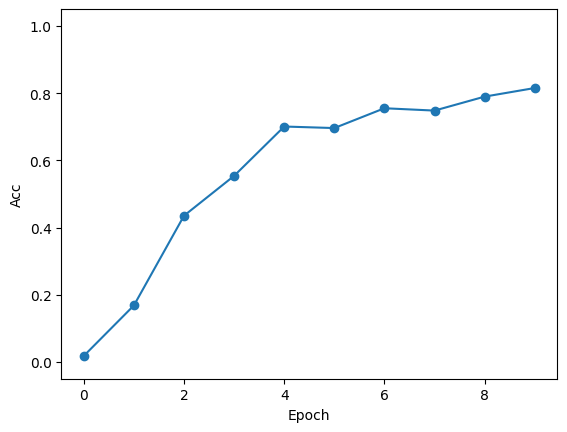

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from attention_seq2seq import AttentionSeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 64
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(-0.05, 1.05)
plt.show()


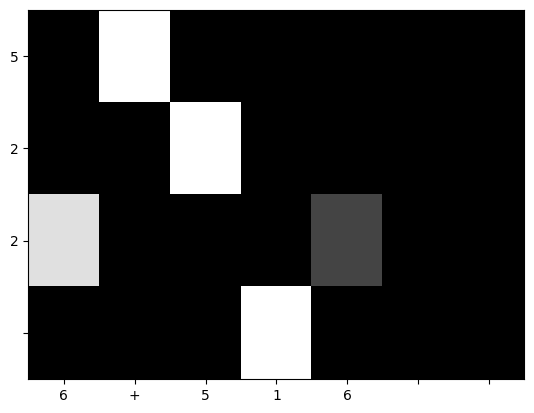

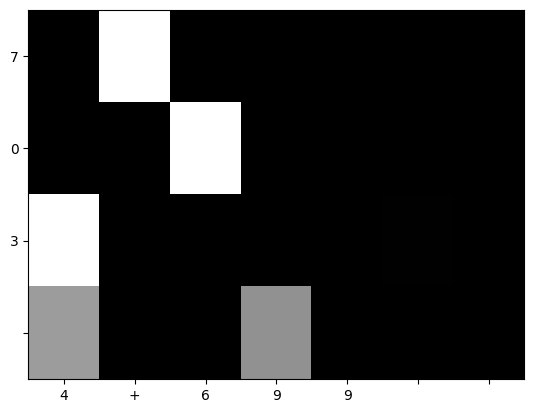

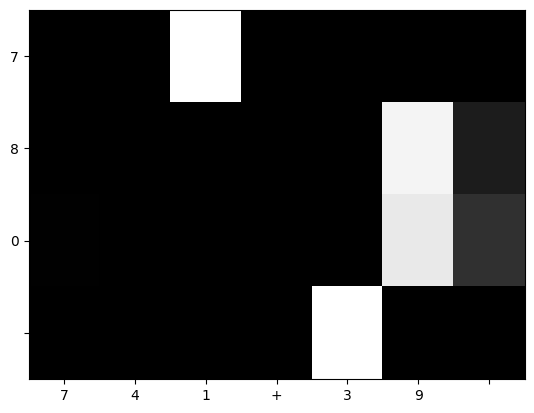

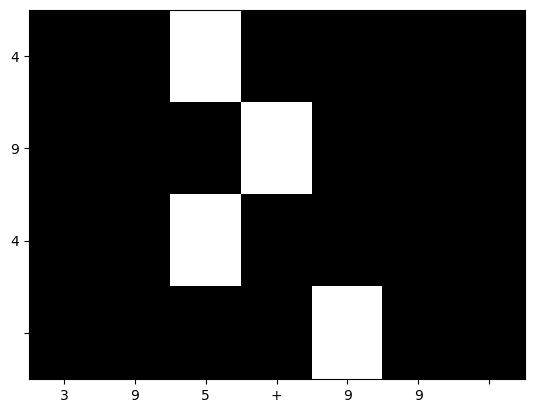

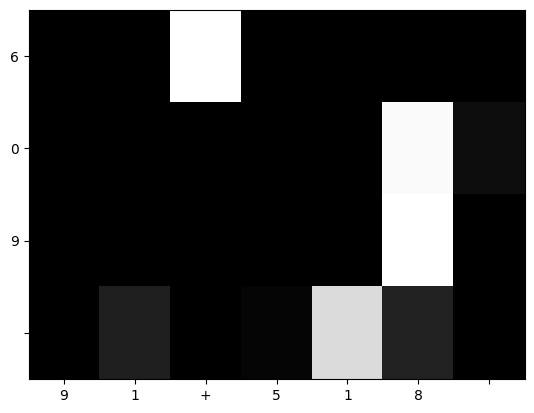

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)
